In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, concatenate, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_images(path, size=(224, 224)):
    images = []
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img = load_img(img_path, target_size=size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Paths to images and masks
images_path = '/content/drive/MyDrive/ayrik1/original_images'
masks_path = '/content/drive/MyDrive/ayrik1/label_images_semantic'

# Load images and masks
images = load_images(images_path)
masks = load_images(masks_path)

# Normalize images
images = images / 255.0

# Convert masks to integer and remove any extra channels
masks = masks.astype(int)
if masks.shape[-1] == 3:  # Assuming masks have 3 channels
    masks = masks[:, :, :, 0]  # Use only the first channel

# Check if masks are correct
print(f"Unique values in masks before one-hot encoding: {np.unique(masks)}")

Unique values in masks before one-hot encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [ ]:
# One-hot encode the masks
num_classes = np.max(masks) + 1
masks = tf.keras.utils.to_categorical(masks, num_classes=num_classes)

# Ensure masks have the shape (num_samples, 224, 224, num_classes)
print(f"Shape of masks after one-hot encoding: {masks.shape}")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

Shape of masks after one-hot encoding: (78, 224, 224, 23)


Epoch 1/101
4/4 [==============================] - 21s 5s/step - loss: 6.9472 - accuracy: 0.1517 - val_loss: 3.4182 - val_accuracy: 0.0857
Epoch 2/101
4/4 [==============================] - 2s 415ms/step - loss: 3.1245 - accuracy: 0.0779 - val_loss: 2.7035 - val_accuracy: 0.2924
Epoch 3/101
4/4 [==============================] - 2s 431ms/step - loss: 2.8608 - accuracy: 0.1253 - val_loss: 2.6765 - val_accuracy: 0.1053
Epoch 4/101
4/4 [==============================] - 1s 374ms/step - loss: 2.8018 - accuracy: 0.1263 - val_loss: 2.6009 - val_accuracy: 0.2954
Epoch 5/101
4/4 [==============================] - 1s 352ms/step - loss: 2.7583 - accuracy: 0.1471 - val_loss: 2.6007 - val_accuracy: 0.2968
Epoch 6/101
4/4 [==============================] - 1s 349ms/step - loss: 2.7913 - accuracy: 0.1479 - val_loss: 2.5508 - val_accuracy: 0.2959
Epoch 7/101
4/4 [==============================] - 1s 345ms/step - loss: 2.7098 - accuracy: 0.1473 - val_loss: 2.5322 - val_accuracy: 0.2944
Epoch 8/101
4/4

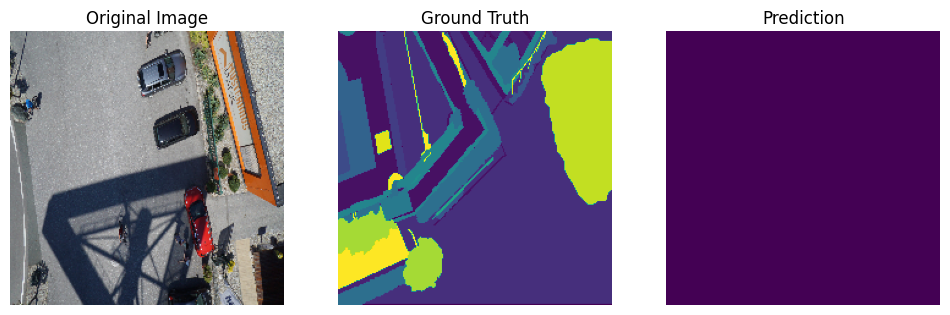

In [ ]:
def build_resnet_unet(input_shape, num_classes):
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder
    for layer in resnet.layers:
        layer.trainable = False

    # Decoder
    x = resnet.output
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = concatenate([x, resnet.get_layer('conv4_block6_out').output])

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = concatenate([x, resnet.get_layer('conv3_block4_out').output])

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = concatenate([x, resnet.get_layer('conv2_block3_out').output])

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = concatenate([x, resnet.get_layer('conv1_relu').output])

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    return Model(inputs=resnet.input, outputs=x)

input_shape = (224, 224, 3)
model = build_resnet_unet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=101, batch_size=16)

# Function to display results
def display_results(image, mask, prediction):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(np.argmax(mask, axis=-1))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(np.argmax(prediction, axis=-1))
    plt.axis('off')

    plt.show()

# Predict on a validation image
sample_image = X_val[0]
sample_mask = y_val[0]
sample_pred = model.predict(np.expand_dims(sample_image, axis=0))

display_results(sample_image, sample_mask, sample_pred[0])